In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import wordnet as wn
import random
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel 


/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tmp/ipykernel_907/9775234.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_sba['NAICS'] = df_clean_sba['NAICS'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
/tmp/ipykernel_907/9775234.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_sba.rename(columns={'DESCRIPTION_OF_OPERATIONS': 'BUSINESS_DESCRIPTION'}, inplace=True)


  NAICS                               BUSINESS_DESCRIPTION
0  [72]  Zenyai Viet Cajun & Pho Restaurant is dedicate...
1  [54]  Kilduff Underground Engineering, Inc. (KUE) is...
2  [45]  024™ is a premium home fragrance brand that de...
3  [56]  Our Services include Office Cleaning Carpet cl...
4  [62]                    NYS Licensed Home Health Agency
NAICS
54    39236
23    29307
33    17546
56    13565
42     7540
48     4574
61     4404
32     3471
62     3218
81     3002
11     2993
53     2821
51     1990
31     1437
22     1170
72     1140
71     1005
49      838
21      745
45      593
44      531
52      459
92       30
55       23
Name: count, dtype: int64


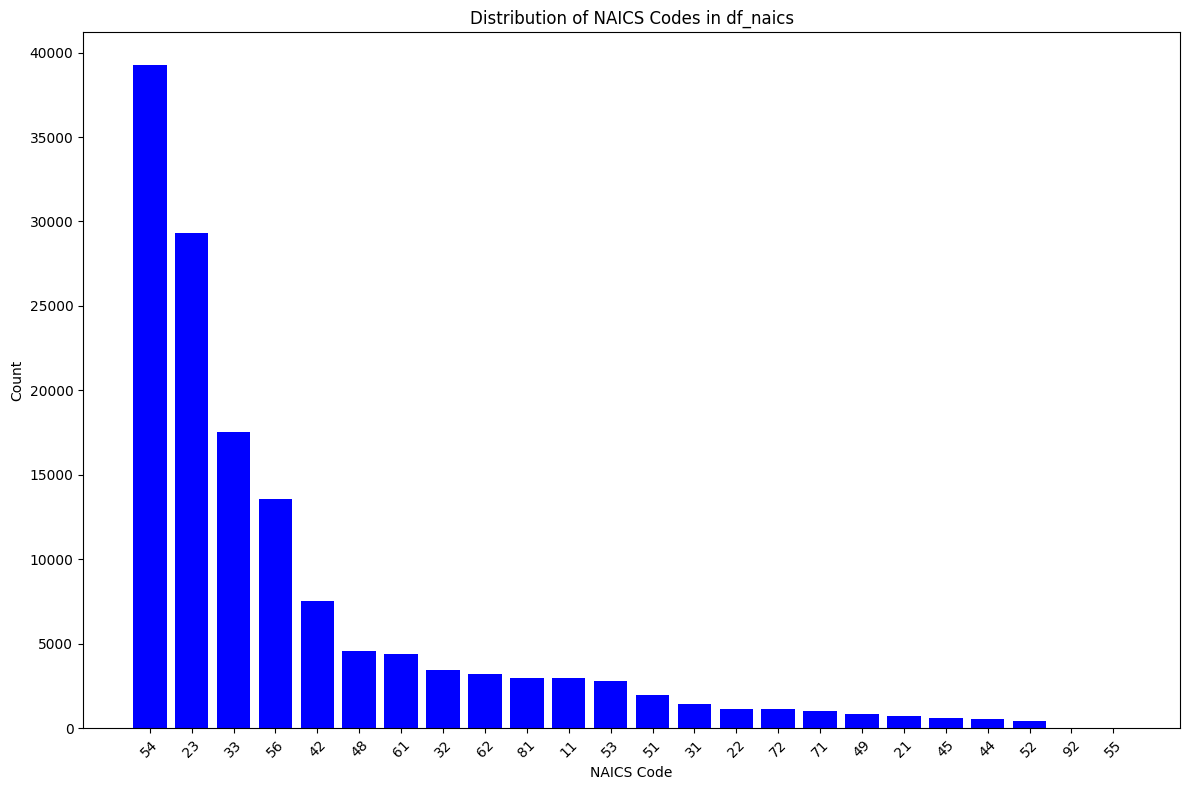

Número de filas con más de un código NAICS: 28001


In [12]:
ROUTE_SBA= '../src/data/sba_dataset.csv'
ROUTE_SBS= '../src/data/SBS_Certified_Business_List.csv'
df_sba = pd.read_csv(ROUTE_SBA) 
df_sba = df_sba[['NAICS', 'DESCRIPTION_OF_OPERATIONS']]
df_sbs = pd.read_csv(ROUTE_SBS) 
df_certified_business_processed: pd.DataFrame = df_sbs.dropna(subset=['Business_Description'])[['ID6_digit_NAICS_code', 'Business_Description']]
df_certified_business_processed.columns = ['NAICS', 'BUSINESS_DESCRIPTION']
df_certified_business_processed['NAICS'] = df_certified_business_processed['NAICS'].astype(str)
df_certified_business_processed['NAICS'] = df_certified_business_processed['NAICS'].apply(lambda x: x.split(',') if isinstance(x, str) else [x])

df_clean_sba = df_sba.dropna()
df_clean_sba['NAICS'] = df_clean_sba['NAICS'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

df_clean_sba.rename(columns={'DESCRIPTION_OF_OPERATIONS': 'BUSINESS_DESCRIPTION'}, inplace=True)
df_naics = pd.concat([df_certified_business_processed, df_clean_sba], ignore_index=True)


def truncate_naics_codes(df: pd.DataFrame, digits: int) -> pd.DataFrame:
    # Asegurar que la columna NAICS existe y es de tipo lista
    if 'NAICS' in df.columns:
        # Aplicar una función a la columna NAICS que trunca cada código en la lista a los dígitos especificados
        df['NAICS'] = df['NAICS'].apply(
            lambda naics_list: [str(code).strip()[:digits] for code in naics_list]
        )
    return df

df_naics=truncate_naics_codes(df_naics,2)
print(df_naics.head())

def count_unique_naics(df: pd.DataFrame):
    
    if 'NAICS' not in df.columns:
        print("La columna 'NAICS' no está presente en el DataFrame.")
        return
    
    flattened_naics = df['NAICS'].explode()
    naics_counts = flattened_naics.value_counts()

    return naics_counts 

unique_naics_count = count_unique_naics(df_naics)
print(unique_naics_count)

expanded_naics = df_naics['NAICS'].explode()
naics_counts = expanded_naics.value_counts()
naics_counts_df = pd.DataFrame({'NAICS': naics_counts.index, 'Count': naics_counts.values})

plt.figure(figsize=(12, 8))

plt.bar(naics_counts_df['NAICS'], naics_counts_df['Count'], color='blue')
plt.xlabel('NAICS Code')
plt.ylabel('Count')
plt.title('Distribution of NAICS Codes in df_naics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

count_rows = df_clean_sba[df_clean_sba['NAICS'].apply(lambda x: len(x) > 1)].shape[0]

print(f'Número de filas con más de un código NAICS: {df_naics.shape[0]}')

In [14]:
expanded_naics = df_naics['NAICS'].explode().reset_index()
one_hot_encoded = pd.get_dummies(expanded_naics, columns=['NAICS'])
df_naics_encoded = one_hot_encoded.groupby('index').sum()
df_naics_encoded.reset_index(drop=True, inplace=True)
df_naics_final = pd.concat([df_naics.drop('NAICS', axis=1), df_naics_encoded], axis=1)
df_naics_final.columns = [col.replace('NAICS_', '') if 'NAICS_' in col else col for col in df_naics_final.columns]
print(df_naics_final.head())


                                BUSINESS_DESCRIPTION  11  21  22  23  31  32  \
0  Zenyai Viet Cajun & Pho Restaurant is dedicate...   0   0   0   0   0   0   
1  Kilduff Underground Engineering, Inc. (KUE) is...   0   0   0   0   0   0   
2  024™ is a premium home fragrance brand that de...   0   0   0   0   0   0   
3  Our Services include Office Cleaning Carpet cl...   0   0   0   0   0   0   
4                    NYS Licensed Home Health Agency   0   0   0   0   0   0   

   33  42  44  ...  53  54  55  56  61  62  71  72  81  92  
0   0   0   0  ...   0   0   0   0   0   0   0   1   0   0  
1   0   0   0  ...   0   1   0   0   0   0   0   0   0   0  
2   0   0   0  ...   0   0   0   0   0   0   0   0   0   0  
3   0   0   0  ...   0   0   0   1   0   0   0   0   0   0  
4   0   0   0  ...   0   0   0   0   0   1   0   0   0   0  

[5 rows x 25 columns]
